In [2]:
import pymc
import theano
import copy
import importlib
import numpy as np
import pandas as pn
import math
import matplotlib.pyplot as plt
%matplotlib inline


import sys

sys.path.append("../../gempy")
import gempy as gp
from gempy import Topology as tp

# sys.path.append("../../pynoddy")
# import pynoddy
# import pynoddy.history
# import pynoddy.output
# import pynoddy.events
# import pynoddy.experiment

In [3]:
geo_data = gp.create_data([337000, 400000, 6640000, 6710000, -18000, 1000],
                          resolution = [120,120,120])

geo_data.import_data_csv("input_data/Paper_GU2F_sc_faults_topo_Points.csv", 
                         "input_data/Paper_GU2F_sc_faults_topo_Foliations.csv")

geo_data.calculate_gradient()

In [4]:
np.unique(geo_data.interfaces["formation"])

array(['Abrolhos_Transfer', 'Cadda', 'Cattamarra', 'Coomallo',
       'Cretaceous', 'Darling', 'Eneabba', 'Eneabba_South', 'Hypo_fault_E',
       'Hypo_fault_W', 'Lesueur', 'Permian', 'Urella_North',
       'Urella_South', 'Woodada_Kockatea', 'Yarragadee'], dtype=object)

In [5]:
geo_data.interfaces = geo_data.interfaces[geo_data.interfaces["formation"] != "Cadda"]
geo_data.foliations = geo_data.foliations[geo_data.foliations["formation"] != "Cadda"]
geo_data.interfaces = geo_data.interfaces[geo_data.interfaces["formation"] != "Woodada_Kockatea"]
geo_data.foliations = geo_data.foliations[geo_data.foliations["formation"] != "Woodada_Kockatea"]
geo_data.interfaces = geo_data.interfaces[geo_data.interfaces["formation"] != "Cattamarra"]
geo_data.foliations = geo_data.foliations[geo_data.foliations["formation"] != "Cattamarra"]

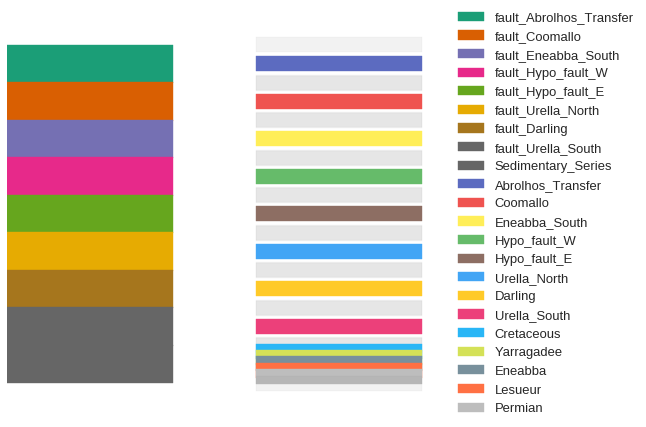

In [6]:
gp.set_series(geo_data, 
              {# "fault_Abrolhos_Transfer": ["Abrolhos_Transfer"],
               "fault_Coomallo": ["Coomallo"],
               "fault_Eneabba_South": ["Eneabba_South"],
               "fault_Hypo_fault_W": ["Hypo_fault_W"],
               "fault_Hypo_fault_E": ["Hypo_fault_E"],
               "fault_Urella_North": ["Urella_North"],
               "fault_Urella_South": ["Urella_South"],
               "fault_Darling": ["Darling"],
               "Sedimentary_Series": ['Cretaceous', 
                                  'Yarragadee', 
                                  #'Cadda', 
                                  #'Cattamarra', 
                                  'Eneabba',
                                  'Lesueur',
                                  #'Woodada_Kockatea', 
                                  'Permian']
               # "fault_Eneabba_North": ["Eneabba_North"]
              }, order_series = ["fault_Abrolhos_Transfer",
                                  "fault_Coomallo",
                                  "fault_Eneabba_South",
                                  "fault_Hypo_fault_W",
                                  "fault_Hypo_fault_E",
                                  "fault_Urella_North",
                                  "fault_Darling",
                                  "fault_Urella_South",
                                  "Sedimentary_Series"],
              order_formations= ["Abrolhos_Transfer",
                                 "Coomallo",
                                 "Eneabba_South",
                                 "Hypo_fault_W",
                                 "Hypo_fault_E",
                                 "Urella_North",
                                 "Urella_South", 
                                 "Darling",
                                   
                                      'Cretaceous', 
                                      'Yarragadee', 
                                      #'Cadda', 
                                      #'Cattamarra', 
                                      'Eneabba',
                                      'Lesueur',
                                      #'Woodada_Kockatea', 
                                      'Permian'])

geo_data.set_formation_number()
geo_data.order_table()

In [7]:
geo_data.fault_relation[0,1:] = 1
#geo_data.fault_relation[5,6:] = 1
geo_data.fault_relation

array([[ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [7]:
#geo_data = gp.select_series(geo_data, ["fault_Hypo_fault_W",  "fault_Hypo_fault_E", "Sedimentary_Series"]) # "fault_Hypo_fault_E",

In [8]:
geo_data.get_formations()

array(['Abrolhos_Transfer', 'Coomallo', 'Eneabba_South', 'Hypo_fault_W',
       'Hypo_fault_E', 'Urella_North', 'Darling', 'Urella_South',
       'Cretaceous', 'Yarragadee', 'Eneabba', 'Lesueur', 'Permian'], dtype=object)

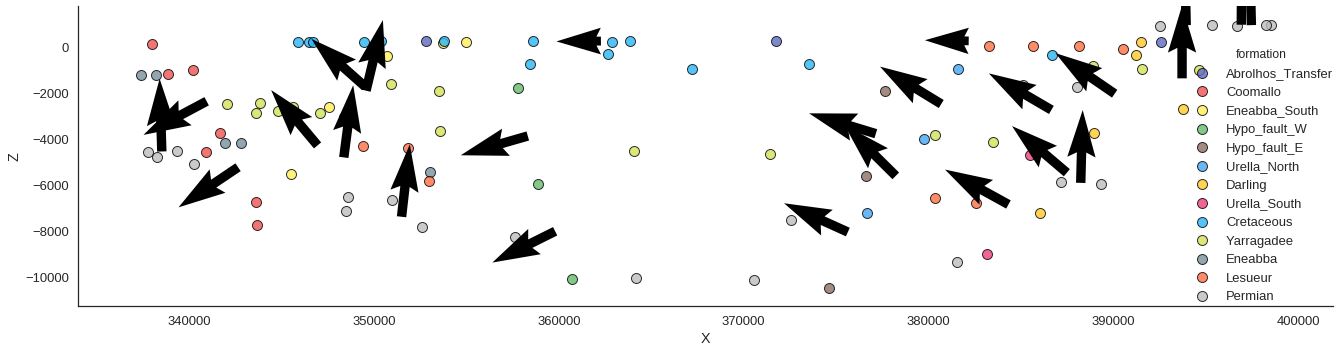

In [8]:
%matplotlib inline
gp.plot_data(geo_data)
plt.tight_layout()
#plt.savefig("input_data.pdf")

In [33]:
gp.plot_data_3D(geo_data)

In [9]:
#geo_data = gp.select_series(geo_data,  ["fault_Hypo_fault_E", "Sedimentary_Series"]) # "fault_Coomallo", "fault_Hypo_fault_W", "fault_Hypo_fault_E", "fault_Urella_South",
interp_data = gp.InterpolatorInput(geo_data, dtype="float64")#, verbose=["potential_field_iter"])

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [11]:
interp_data.interpolator.tg.n_formation.get_value()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [10]:
#%%timeit
lith_block, fault_block = gp.compute_model(interp_data)

potential_field_iter __str__ = [ 950.2357258   949.99875619  949.76169044]
potential_field_iter __str__ = [ 919.98331223  919.85082329  909.73864963]
potential_field_iter __str__ = [ 833.83727973  817.55809897  817.35198278]
potential_field_iter __str__ = [ 843.94456274  843.72515098  821.66616   ]
potential_field_iter __str__ = [ 733.53162177  716.96797059  716.76051773]
potential_field_iter __str__ = [ 671.67482286  671.52347904  642.88203887]
potential_field_iter __str__ = [ 650.15772854  649.97745917  649.80203252]
potential_field_iter __str__ = [ 606.02744041  605.82570749  602.72614257]
potential_field_iter __str__ = [ 551.57974326  551.53971951  551.49703297  551.4748743   551.4701449
  551.436535    551.09460825]


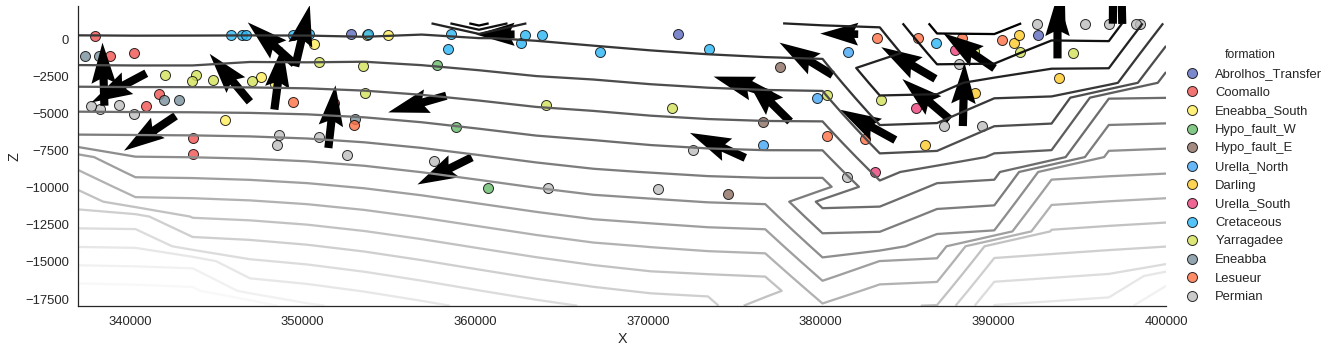

In [9]:
gp.plot_potential_field(geo_data, lith_block[1], 0)

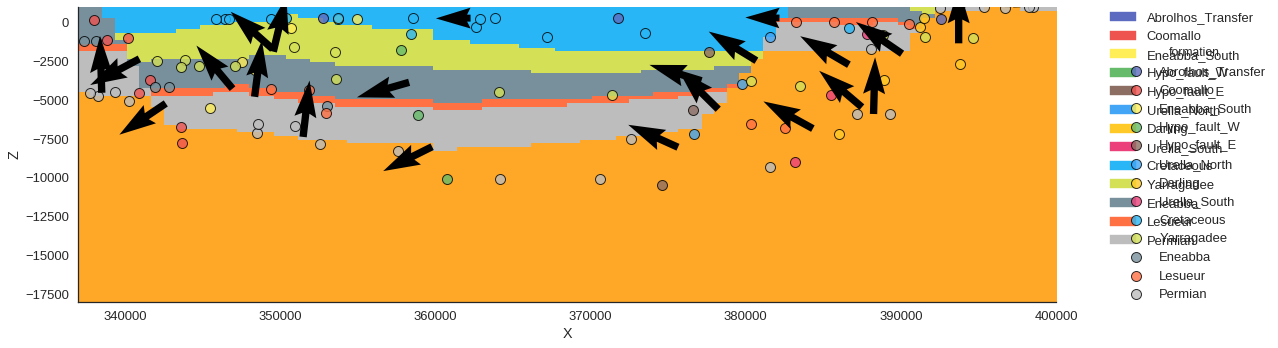

In [9]:
gp.plot_section(geo_data, lith_block[0], 60, direction="y", plot_data=True)

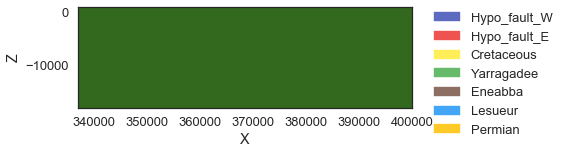

In [185]:
gp.plot_section(geo_data, fault_block[1], 5, direction="y")

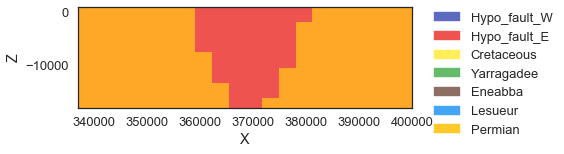

In [186]:
gp.plot_section(geo_data, fault_block[2], 5, direction="y")

In [13]:
gp.plot_data_3D(geo_data)

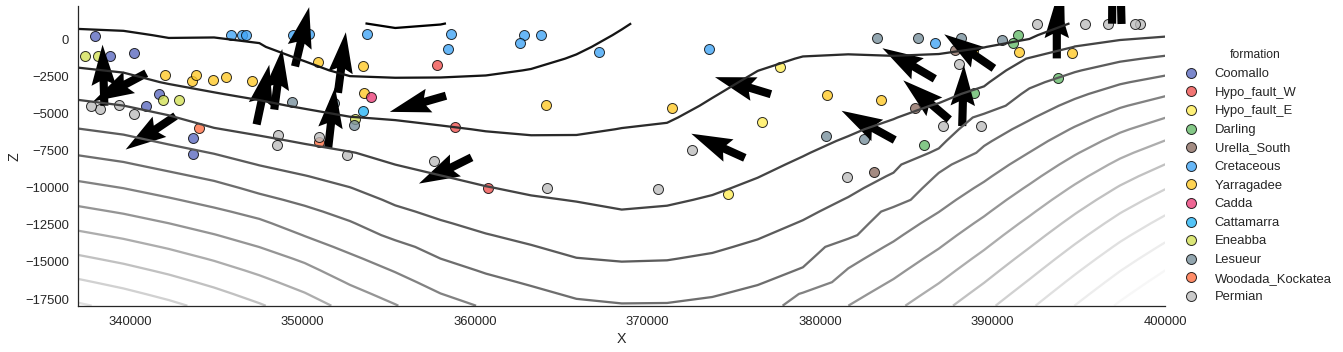

In [90]:
gp.plot_potential_field(geo_data, lith_block[1], 15)

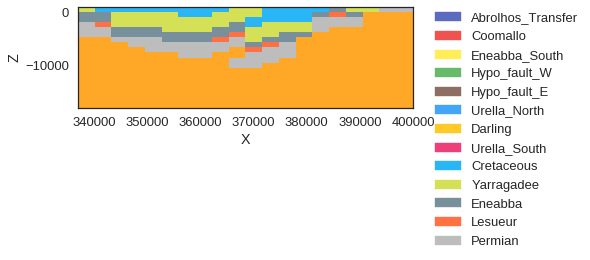

In [12]:
gp.plot_section(geo_data, lith_block[0], 15)

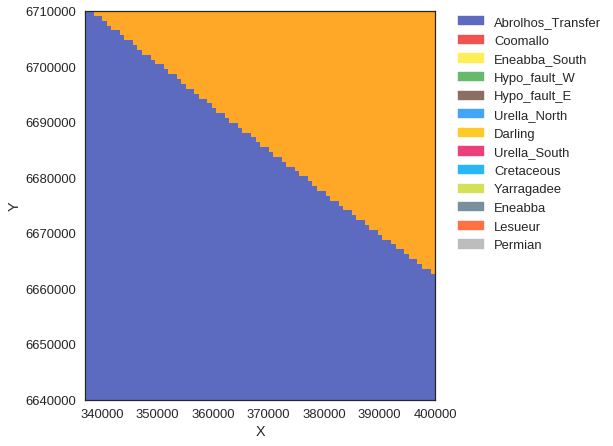

In [10]:
gp.plot_section(geo_data, fault_block[0], 20, direction="z")

In [22]:
gp.plot_data_3D(geo_data)

In [24]:
interp_data.potential_at_interfaces[7]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,  -8.03554983e+14,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

In [32]:
fault_block[-1]

array([ -8.03554983e+14,  -8.03554983e+14,  -8.03554983e+14, ...,
         5.08956401e+02,   5.08956816e+02,   5.08957232e+02])

In [29]:
fault_block[-1].max()

803554982958371.5

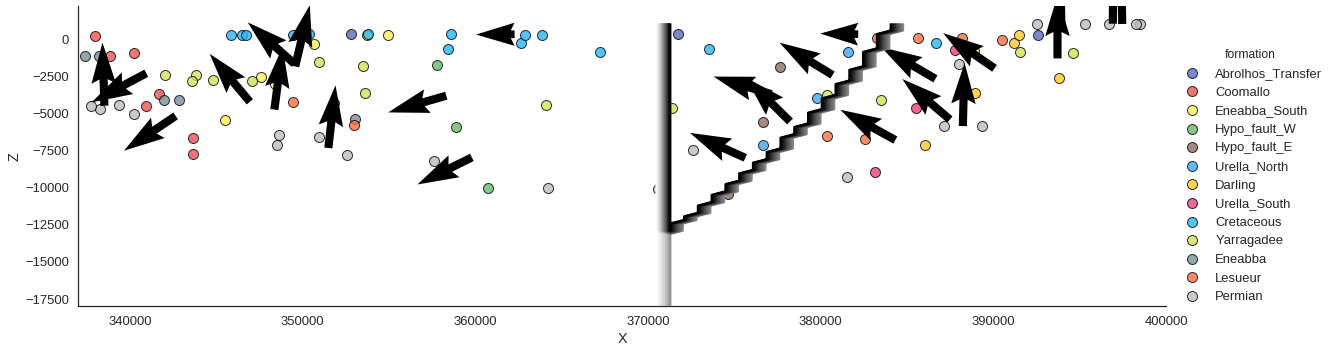

In [31]:
gp.plot_potential_field(geo_data, fault_block[-1], 50)

In [20]:
 lith_block[1].max(),  lith_block[1].min()

(551.38150216928921, 551.00774262453774)

In [17]:
fault_block[1::2]

array([[  9.50102603e+02,   9.50103161e+02,   9.50103714e+02, ...,
          9.49780369e+02,   9.49780396e+02,   9.49780437e+02],
       [  9.19867931e+02,   9.19867570e+02,   9.19867207e+02, ...,
          9.09862279e+02,   9.09862187e+02,   9.09862101e+02],
       [  8.17520543e+02,   8.17521060e+02,   8.17521582e+02, ...,
          8.33687966e+02,   8.33688297e+02,   8.33688632e+02],
       ..., 
       [  6.42983847e+02,   6.42984107e+02,   6.42984366e+02, ...,
          6.71382001e+02,   6.71383088e+02,   6.71384178e+02],
       [  6.26092581e+02,   6.26092721e+02,   6.26092860e+02, ...,
          6.26027527e+02,   6.26029042e+02,   6.26030557e+02],
       [ -8.03554983e+14,  -8.03554983e+14,  -8.03554983e+14, ...,
          5.08956401e+02,   5.08956816e+02,   5.08957232e+02]])

In [11]:
ver, sim = gp.get_surfaces(interp_data, lith_block[1], fault_block[1::2], original_scale=False)

In [19]:
%debug

> /home/miguel/anaconda3/lib/python3.6/site-packages/skimage/measure/_marching_cubes_lewiner.py(199)marching_cubes_lewiner()
    197         level = float(level)
    198         if level < volume.min() or level > volume.max():
--> 199             raise ValueError("Surface level must be within volume data range.")
    200     # spacing
    201     if len(spacing) != 3:

> /home/miguel/PycharmProjects/gempy/gempy/GemPy_f.py(585)get_surface()
    583             spacing=((interp_data.geo_data_res.extent[1] - interp_data.geo_data_res.extent[0]) / interp_data.geo_data_res.resolution[0],
    584                      (interp_data.geo_data_res.extent[3] - interp_data.geo_data_res.extent[2]) / interp_data.geo_data_res.resolution[1],
--> 585                      (interp_data.geo_data_res.extent[5] - interp_data.geo_data_res.extent[4]) / interp_data.geo_data_res.resolution[2]))
    586 
    587 

8


In [80]:
interp_data.potential_at_interfaces

array([[ 94.03024292,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  88.6519928 ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,  84.14245605,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  79.57372284,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
         74.30317688,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.    

In [88]:
interp_data.geo_data_res.interfaces

,X,Y,Z,formation,series,order_series,isFault,formation number,annotations
0,0.316827,0.318339,0.477332,Coomallo,fault_Coomallo,2,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
1,0.280539,0.309687,0.527072,Coomallo,fault_Coomallo,2,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
2,0.290872,0.585367,0.528518,Coomallo,fault_Coomallo,2,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},2}$"
3,0.301642,0.586637,0.507784,Coomallo,fault_Coomallo,2,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},3}$"
4,0.316531,0.588392,0.485136,Coomallo,fault_Coomallo,2,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},4}$"
5,0.296091,0.313395,0.501314,Coomallo,fault_Coomallo,2,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},5}$"
6,0.274037,0.706061,0.537081,Coomallo,fault_Coomallo,2,True,1,"${\bf{x}}_{\alpha \,{\bf{1}},6}$"
7,0.445659,0.356502,0.459864,Hypo_fault_W,fault_Hypo_fault_W,4,True,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$"
8,0.4233,0.349489,0.522522,Hypo_fault_W,fault_Hypo_fault_W,4,True,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$"
9,0.431563,0.352081,0.490938,Hypo_fault_W,fault_Hypo_fault_W,4,True,2,"${\bf{x}}_{\alpha \,{\bf{2}},2}$"


In [12]:
gp.plot_surfaces_3D(interp_data.geo_data_res, ver, sim, alpha=1)
